<a href="https://colab.research.google.com/github/StratagemGIS/notebooks/blob/main/machine_learning/01_lulc_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landuse / Landcover Classification using Sentinel-2 and XGBoost

## Libraries

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.6 MB/s eta 0:00:00


In [ ]:
import pooch
import geopandas as gpd
import rasterio as rio
from xgboost import XGBRFClassifier

## Data Preparation

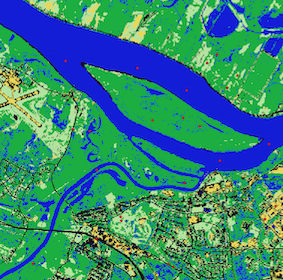](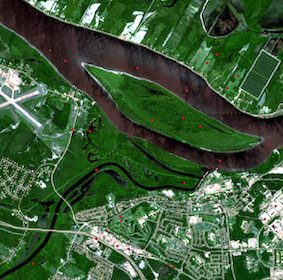)

In [ ]:
sentinel2_img = pooch.retrieve(
    'https://github.com/StratagemGIS/datasets/raw/main/raster/oromocto_jun2021_composite.tif',
    known_hash='e08df41e0f301d684f9ed1a487b9abccaf431fd3df25fa5f10da82d44e6b733d'
)

tr_data = pooch.retrieve(
    'https://github.com/StratagemGIS/datasets/raw/main/vector/oromocto_jun2021_composite_trdata.gpkg',
    known_hash='3b3aa4b0a3940db007f9d90e83bb9c1fb9d24bcb51ec0f3b476c5fbfb852bd7b'
)

out_tif = 'classified.tif'

In [ ]:
df = gpd.read_file(tr_data)
points = [(row.geometry.x, row.geometry.y) for ix, row in df.iterrows()]

In [ ]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
with rio.open(sentinel2_img) as src:
    cfg = src.profile
    data = src.read()
    df[bands] = list(src.sample(points))

## Training the Model

In [ ]:
rf = XGBRFClassifier(random_state=32)
rf.fit(df[bands], df['class'])

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=32, reg_alpha=None, ...)

## Prediction

In [ ]:
n, h, w = cfg['count'], cfg['height'], cfg['width']
pred = rf.predict(data.reshape(n, h * w).T).reshape(h, w)
cfg.update(count=1)
with rio.open(out_tif, 'w', **cfg) as out:
    out.write(pred, 1)

# Result

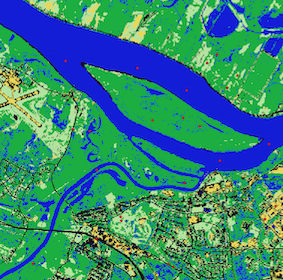



# Full Code

In [ ]:
"""
Vaasudevan Srinivasan 🧑🏻‍💻
StratagemGIS Solutions
Script to train and generate Landuse Landcover (lulc) map
"""

# Libraries
import geopandas as gpd
import rasterio as rio
from xgboost import XGBRFClassifier


def lulc(sentinel2_img, tr_data, out_tif):

    # Data Preparation
    df = gpd.read_file(tr_data)
    points = [(row.geometry.x, row.geometry.y) for ix, row in df.iterrows()]
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    with rio.open(sentinel2_img) as src:
        cfg = src.profile
        data = src.read()
        df[bands] = list(src.sample(points))

    # Training the Model
    rf = XGBRFClassifier(random_state=32)
    rf.fit(df[bands], df['class'])

    # Prediction
    n, h, w = cfg['count'], cfg['height'], cfg['width']
    pred = rf.predict(data.reshape(n, h * w).T).reshape(h, w)
    cfg.update(count=1)
    with rio.open(out_tif, 'w', **cfg) as out:
        out.write(pred, 1)